# Imports

In [5]:
# Import Modules
import os
import pandas as pd
import numpy as np
from itertools import chain
import cv2
import split_folders

# Plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

# Metrics
from sklearn.metrics import confusion_matrix, roc_curve,auc, classification_report

# Deep Learning
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input as mobilenet_preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img

2.0.0


# The dataset

The dataset used for training are **100,000 HE image tiles** from 86 Colorectal Cancer tissue slides. The images are classified into **9** different tissue types: **ADI** (adipose tissue), **BACK** (background), **DEB** (debris), **LYM** (lymphocytes), **MUC** (mucus), **MUS** (smooth muscle), **NORM** (normal colon mucosa), **STR** (cancer-associated stroma), and **TUM** (colorectal adenocarcinoma epithelium) and are organized in 9 different folders.

In [5]:
base_dir = "/floyd/input/colorectal_cancer"
input_ = os.path.join(base_dir,"NCT-CRC-HE-100K")

# split data into training, vlaidation and testing sets
split_folders.ratio(input_, 'output', seed = 101, ratio=(0.8, 0.1, 0.1))

data_dir = os.path.join('/floyd/home','output')

# Define train, valid and test directories
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

In [6]:
os.listdir('output')

['val', 'test', 'train']

Text(0.5, 0, 'Number of samples')

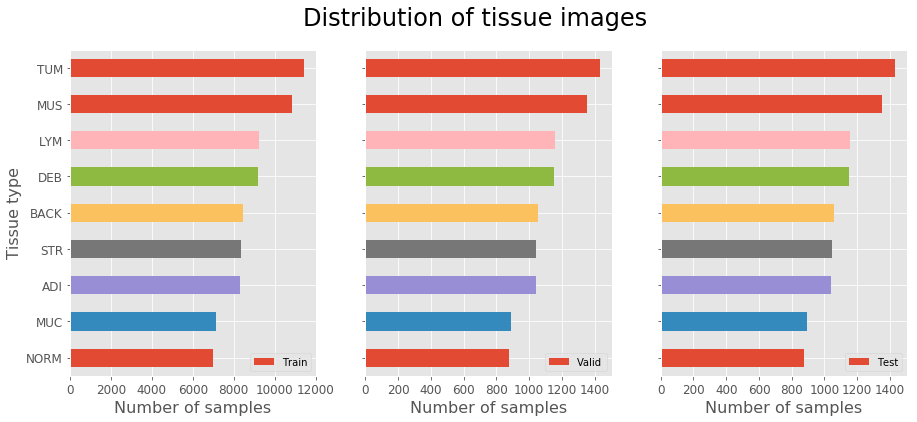

In [8]:
# Plot number of samples for each class in train_dir

# Path to all three directories
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Tissue classes list
class_ = os.listdir(train_dir)

# Instantiate empty lists to add the number of samples
trn_num_samples = []
val_num_samples = []
test_num_samples = []

# Count the number of samples in train_dir
for dir_ in [train_dir, valid_dir, test_dir]:
    if dir_ == train_dir:
        for dir_ in os.listdir(dir_):
            trn_num_samples.append(len(os.listdir(os.path.join(train_dir, dir_))))

    elif dir_ == valid_dir:
        for dir_ in os.listdir(dir_):
            val_num_samples.append(len(os.listdir(os.path.join(valid_dir, dir_))))
    
    else:
        for dir_ in os.listdir(dir_):
            test_num_samples.append(len(os.listdir(os.path.join(test_dir, dir_))))

# Make a dataframe with the computed stats 
# Step 1: Make a dictionary and populate the dictionary
stats = {}
stats['Tissue_type'] = class_
stats['Train'] = trn_num_samples
stats['Valid'] = val_num_samples
stats['Test'] = test_num_samples
# Step 2: Make a dataframe and sort its values based on train data 
df = pd.DataFrame(stats).sort_values(['Train'], ascending=True)


# Plot the data
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,6), sharey=True)
fig.suptitle("Distribution of tissue images", fontsize=24)

df.plot(kind='barh', x="Tissue_type", y='Train', ax = ax1, fontsize=12)
ax1.set_xlabel('Number of samples', fontsize=16)
ax1.set_ylabel('Tissue type', fontsize=16)

df.plot(kind='barh', x="Tissue_type", y='Valid', ax = ax2, fontsize=12)
ax2.set_xlabel('Number of samples', fontsize=16)

df.plot(kind='barh', x="Tissue_type", y='Test', ax = ax3, fontsize=12)
ax3.set_xlabel('Number of samples', fontsize=16)


# Data Augmentation and EDA

Data augmentation is a strategy that adds noise and increase the diversity of the training data. It is a form of regularization and generalizes tbe model.  

The method purposely perturbs training examples, changing their appearance slightly, before passing them into the network for training. This partially alleviates the need to gather more training data.

Initialize each of our generators with data augmentation techniques such as horizontal flipping, vertical flipping, shear, rotation and shift are commonly used to train large neural networks.

In [9]:
# Data Augmentation
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   shear_range=0.4,
                                   width_shift_range=0.25,
                                   height_shift_range=0.25,
                                   rotation_range=45,
                                   fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [2]:
# Train ImageDataGenerator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 64,
                                                    target_size = (224,224),
                                                    class_mode = 'categorical',
                                                    shuffle=True,
                                                    seed=42,
                                                    color_mode='rgb')

valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    batch_size=64,
                                                    target_size=(224,224),
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    seed=42,
                                                    color_mode='rgb')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                batch_size=1,
                                                target_size=(224,224),
                                                class_mode='categorical',
                                                shuffle=False,
                                                seed=42,
                                                color_mode='rgb')

# Plot images for each class

In [13]:
# Test data
filenames = test_generator.filenames
nb_samples = len(filenames)

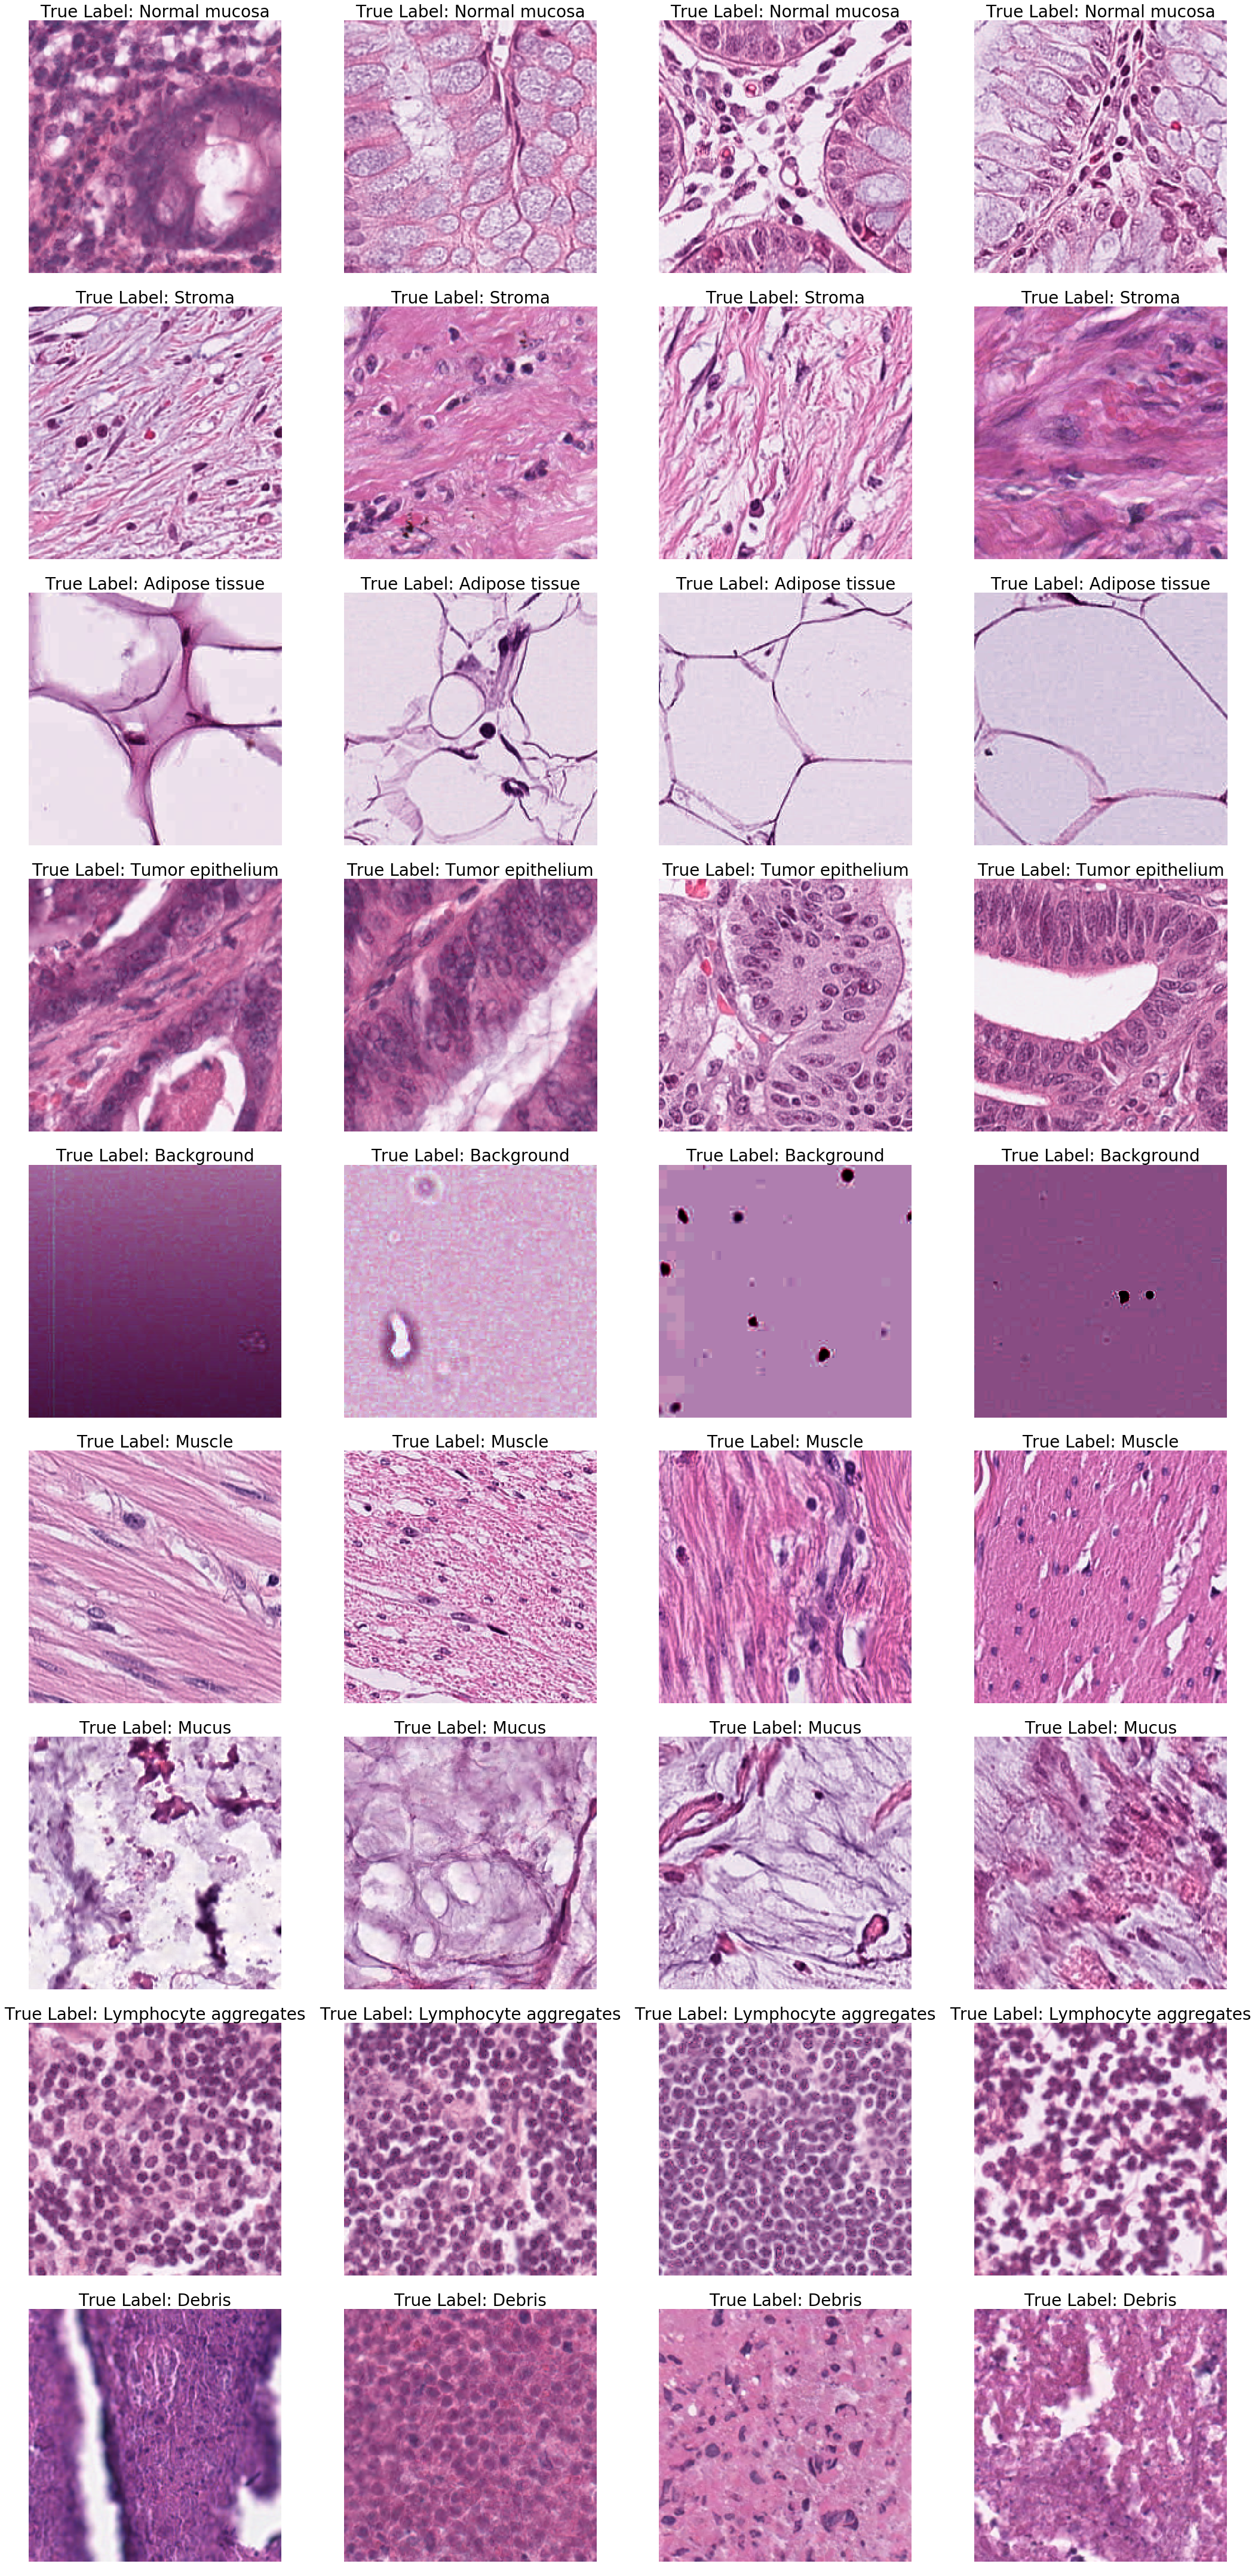

In [11]:
# Get model class_labels and inverted class_labels as class_names
class_labels = train_generator.class_indices
class_names = {value:key for key,value in class_labels.items()}

# Tissue types dictionary mapping class names with full names
tissue_types = {"ADI": "Adipose tissue",
               "BACK": "Background",
               "DEB": "Debris",
               "LYM": "Lymphocyte aggregates",
               "MUC": "Mucus", 
               "MUS": "Muscle",
               "NORM": "Normal mucosa", 
               "STR": "Stroma",
               "TUM": "Tumor epithelium"}

# List of images to plot: 4 images from each class in the training data
images_to_plot = [os.path.join(train_dir, subdir_, fname) for subdir_ in os.listdir(train_dir) for fname in os.listdir(os.path.join(train_dir, subdir_))[:4]]

fig = plt.figure(figsize=(30,60))
fig.subplots_adjust(top=0.88)
columns = 4
rows = 9

for i in range(1, columns*rows+1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(mpimg.imread(images_to_plot[i-1]))
    plt.axis('off')
    title = images_to_plot[i-1].split('/')[-2]
    plt.title("True Label: {}".format(tissue_types[title]), fontsize=28)
    plt.tight_layout()
    
plt.show()